In [1]:

%pprint
import sys
sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

from datetime import timedelta
from matplotlib.text import Text
from notebook_utils import NotebookUtilities
from pandas import DataFrame
import humanize
import matplotlib.pyplot as plt
import os
import pandas as pd
import re

nu = NotebookUtilities(data_folder_path=os.path.abspath('../data'))

In [3]:

# Get all CSVs out of one DataFrame
if nu.pickle_exists('frvrs_logs_df'):
    frvrs_logs_df = nu.load_object('frvrs_logs_df')
    print(frvrs_logs_df.shape)
    # df = frvrs_logs_df.sample(4).dropna(axis='columns', how='all')
    # display(df.T)

(832366, 109)



# Visualize Elapsed Time Spent on Patient

In [4]:

# Get all scenes and an action timeline of each patient and compute the engagement delta
if nu.pickle_exists('engagement_delta_df'):
    engagement_delta_df = nu.load_object('engagement_delta_df')
else:
    actions_list = ['INJURY_RECORD', 'PATIENT_RECORD', 'S_A_L_T_WALK_IF_CAN', 'S_A_L_T_WAVE_IF_CAN', 'S_A_L_T_WAVED']
    rows_list = []
    max_delta_count = 0
    for (session_uuid, scene_index), df1 in nu.get_session_groupby(
    	mask_series=None, extra_column='scene_index'
    ):
    	
        # Get all patients in that period
        for patient_id, df2 in df1.groupby('patient_id'):
            row_dict = {}
            row_dict['session_uuid'] = session_uuid
            row_dict['scene_index'] = scene_index
            row_dict['patient_id'] = patient_id
            
            # Get the timeline for patient engagement
            mask_series = df2.action_type.isin(actions_list)
            xmin = df2[~mask_series].elapsed_time.min(); row_dict['engagement_start'] = xmin
            xmax = df2.elapsed_time.max(); row_dict['engagement_stop'] = xmax
            engagement_delta = xmax - xmin; row_dict['engagement_delta'] = engagement_delta
    
            # Get a sequence of elapsed times for patient engagements
            times_list = [xmin]
            mask_series = df2.action_type.isin(['PATIENT_ENGAGED'])
            times_list += df2[mask_series].sort_values('elapsed_time').elapsed_time.tolist()
    
            # Compute their differences
            deltas_list = []
            for i in range(len(times_list) - 1):
                deltas_list.append(times_list[i + 1] - times_list[i])
    
            # Add these in separate columns
            max_delta_count = max(max_delta_count, len(deltas_list))
            for i, delta in enumerate(deltas_list):
                row_dict[f'delta{i:02d}'] = delta
            
            rows_list.append(row_dict)
    
    engagement_delta_df = DataFrame(rows_list)
    nu.store_objects(engagement_delta_df=engagement_delta_df)

In [5]:

print(engagement_delta_df.columns.tolist())
engagement_delta_df.sample(5).dropna(axis='columns', how='all').T

['session_uuid', 'scene_index', 'patient_id', 'engagement_start', 'engagement_stop', 'engagement_delta', 'delta00', 'delta01', 'delta02', 'delta03', 'delta04', 'delta05', 'delta06', 'delta07', 'delta08', 'delta09', 'delta10', 'delta11', 'delta12', 'delta13', 'delta14', 'delta15', 'delta16', 'delta17', 'delta18', 'delta19', 'delta20', 'delta21', 'delta22', 'delta23', 'delta24']


,5473,5760,9417,6122,2757
session_uuid,87efcdf5-9090-4fa5-afac-25c778924e9a,8f0e76c0-6ff2-4974-b0f7-3f416e22fa90,f3cbb8a9-8d0c-48f0-ac0c-e379ac4d9411,9e0f8037-329b-496a-817a-daae83aa941f,4219eddf-b044-43ad-9e01-c0333fc428c5
scene_index,1,1,1,0,1
patient_id,Gary_1 Root,Mike_5 Root,Bob_0 Root,Gary_3 Root,Lily_1 Root
engagement_start,264955.0,280137.0,226171.0,10748.0,208014.0
engagement_stop,264955,512725,226390,10748,462026
engagement_delta,0.0,232588.0,219.0,0.0,254012.0
delta00,NaN,0.0,NaN,NaN,0.0
delta01,NaN,141647.0,NaN,NaN,NaN
delta02,NaN,90941.0,NaN,NaN,NaN


In [6]:

# Group the engagement delta patients by session and rank order them
if nu.pickle_exists('patient_ranking_df'):
    patient_ranking_df = nu.load_object('patient_ranking_df')
else:
    columns_list = ['patient_ranking', 'engagement_start', 'engagement_delta']
    patient_ranking_df = DataFrame([], columns=columns_list)
    for (session_uuid, scene_index), df in engagement_delta_df.groupby(['session_uuid', 'scene_index']):
        offset = df.engagement_start.min()
        df.engagement_start = df.engagement_start - offset
        # df.engagement_stop = df.engagement_stop - offset
        columns_list = ['index', 'engagement_start', 'engagement_delta']
        df = df.drop_duplicates(
            subset=['engagement_start', 'engagement_delta']
        ).sort_values('engagement_start').reset_index(drop=True).reset_index(drop=False)[columns_list].rename(
            columns={'index': 'patient_ranking'}
        )#.iloc[:max_ranking]
        # group_max_ranking = df.patient_ranking.max()
        # if group_max_ranking > (max_ranking + 1): raise
        patient_ranking_df = pd.concat([patient_ranking_df, df], axis='index')
    nu.store_objects(patient_ranking_df=patient_ranking_df)

In [7]:

print(patient_ranking_df.columns.tolist())
patient_ranking_df.sample(5).dropna(axis='columns', how='all').T

['patient_ranking', 'engagement_start', 'engagement_delta']


,0,0,3,2,8
patient_ranking,0,0,3,2,8
engagement_start,0.0,0.0,2054.0,1050.0,161831.0
engagement_delta,201099.0,0.0,0.0,0.0,33398.0


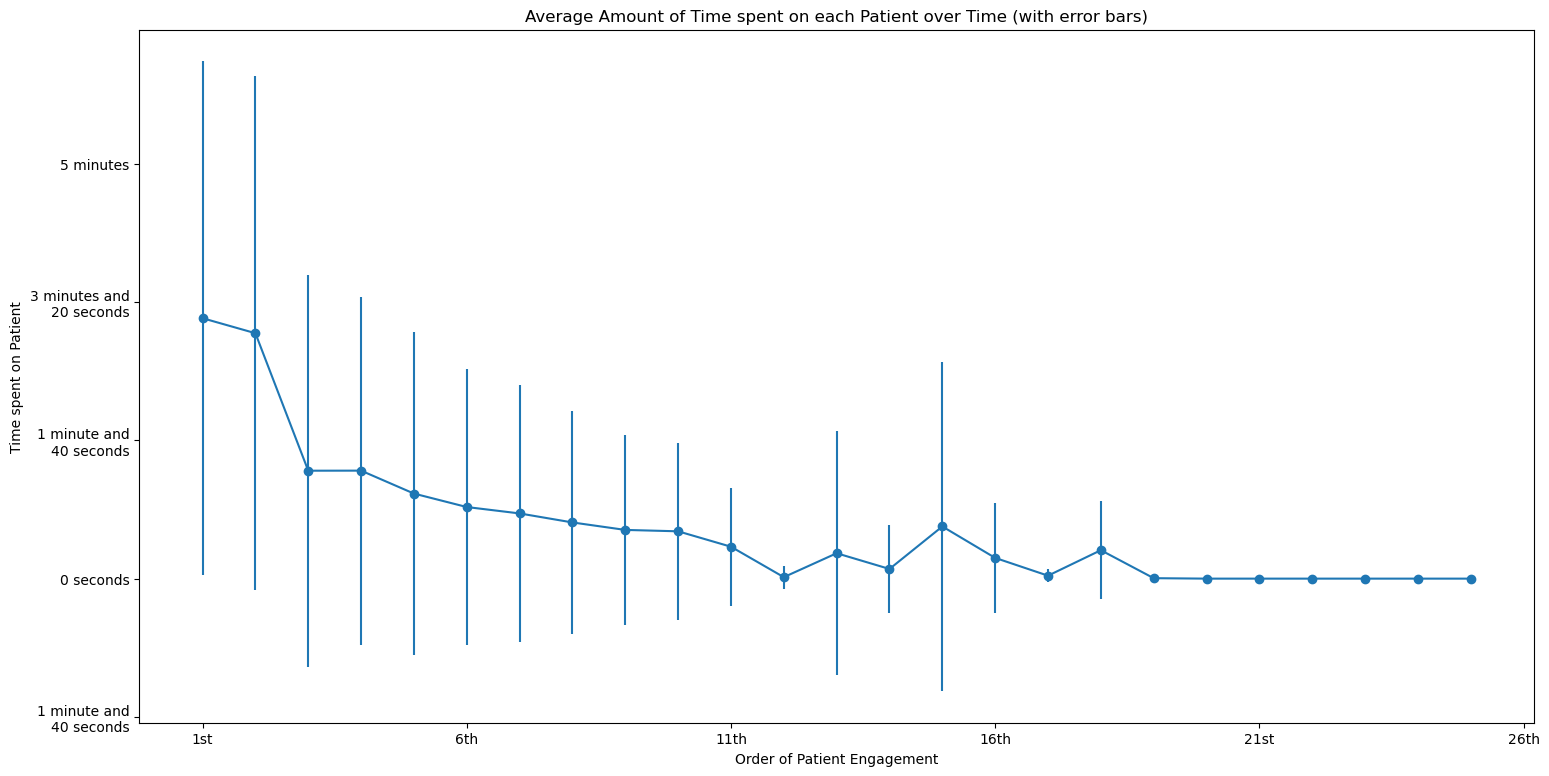

In [8]:

# Display average amount of time spent on each patient over time with error bars
xname = 'patient_ranking'
xlabel = 'Order of Patient Engagement'
get_xtick_text = lambda text_obj: humanize.ordinal(int(text_obj.get_position()[0])+1)
yname = 'engagement_delta'
ylabel = 'Time spent on Patient'
get_ytick_text = lambda text_obj: humanize.precisedelta(
    timedelta(milliseconds=text_obj.get_position()[1])
).replace(', ', ',\n').replace(' and ', ' and\n')
title = 'Average Amount of Time spent on each Patient over Time (with error bars)'
nu.plot_line_with_error_bars(
    df=patient_ranking_df, xname=xname, xlabel=xlabel, xtick_text_fn=get_xtick_text, yname=yname, ylabel=ylabel,
    ytick_text_fn=get_ytick_text, title=title
)

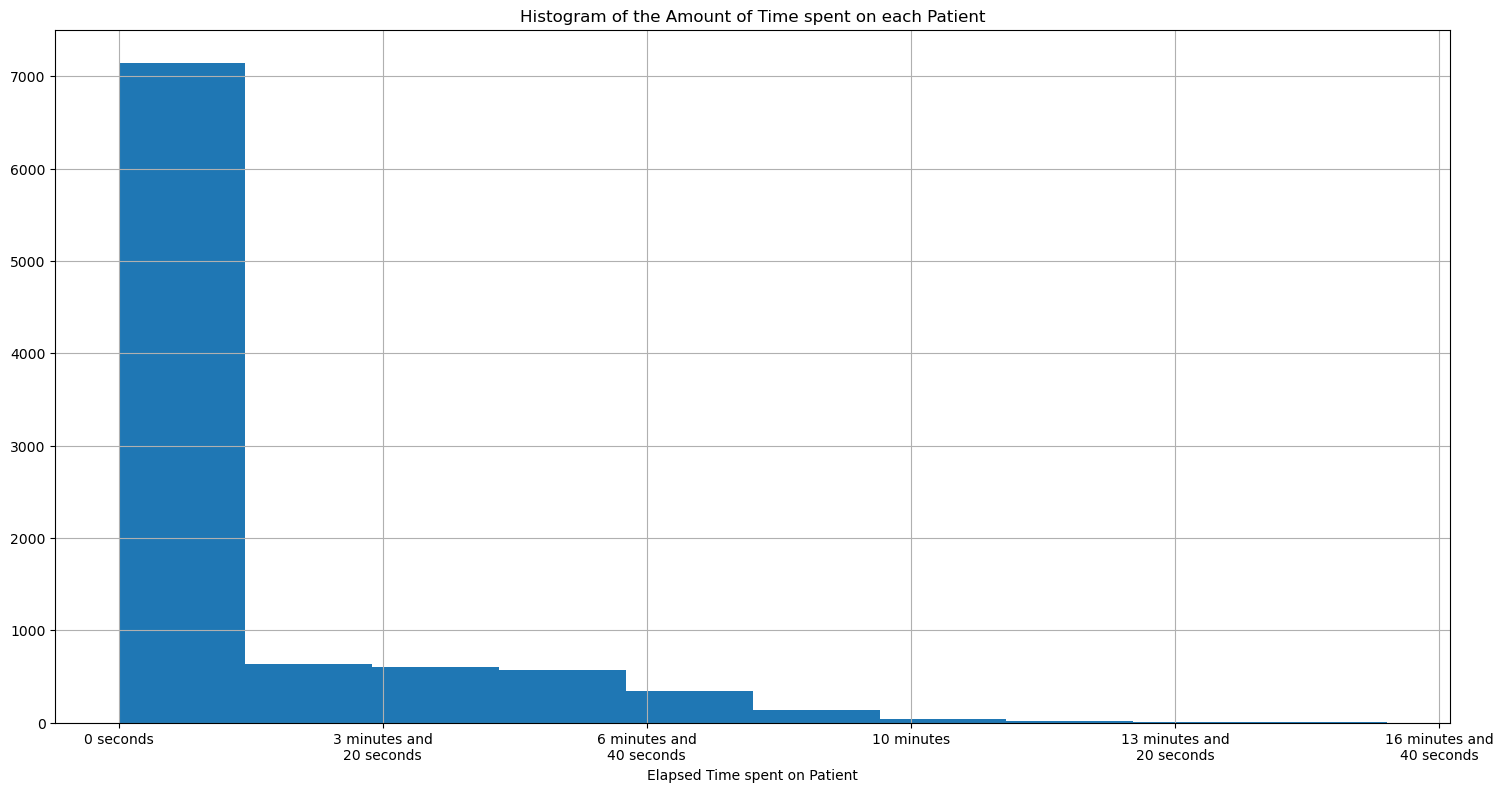

In [9]:

# Get a Histogram of the Amount of Time spent on each Patient
ax = plt.figure(figsize=(18, 9)).add_subplot(1, 1, 1)
engagement_delta_df.engagement_delta.hist(ax=ax)

# Set the title and labels
ax.set_title('Histogram of the Amount of Time spent on each Patient')
ax.set_xlabel('Elapsed Time spent on Patient')

# Humanize x tick labels
xticklabels_list = []
for text_obj in ax.get_xticklabels():
    text_obj.set_text(
        humanize.precisedelta(timedelta(milliseconds=text_obj.get_position()[0])).replace(', ', ',\n').replace(' and ', ' and\n')
    )
    xticklabels_list.append(text_obj)
ax.set_xticklabels(xticklabels_list);

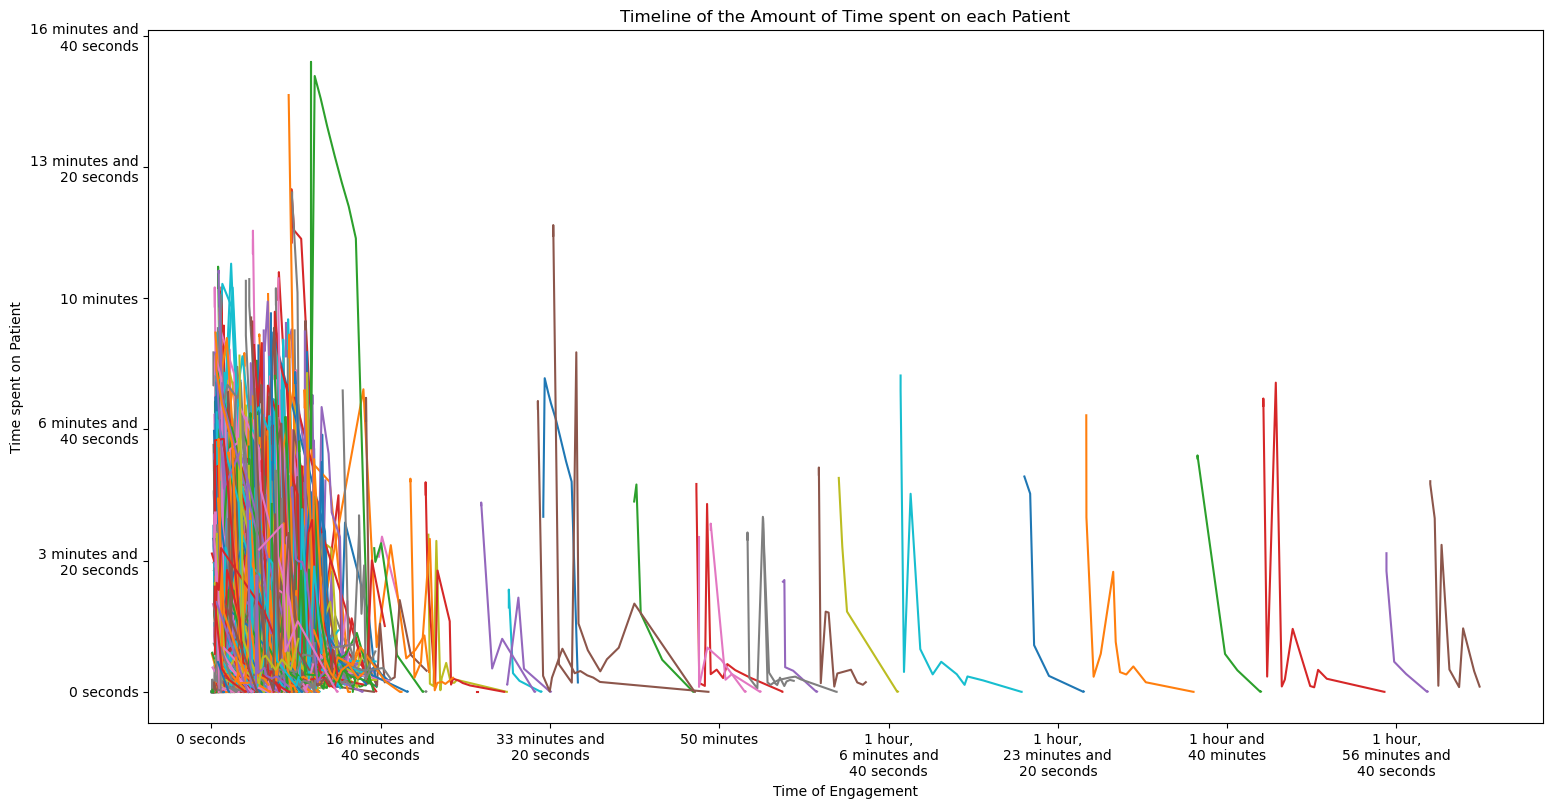

In [10]:

# Add all scenes as line plots of engagement start vs delta
ax = plt.figure(figsize=(18, 9)).add_subplot(1, 1, 1)
for (session_uuid, scene_index), df in engagement_delta_df.groupby(['session_uuid', 'scene_index']):
    df.sort_values('engagement_start').plot(x='engagement_start', y='engagement_delta', kind='line', ax=ax, label=None)

# Humanize x tick labels
xticklabels_list = []
for text_obj in ax.get_xticklabels():
    text_obj.set_text(
        humanize.precisedelta(timedelta(milliseconds=text_obj.get_position()[0])).replace(', ', ',\n').replace(' and ', ' and\n')
    )
    xticklabels_list.append(text_obj)
ax.set_xticklabels(xticklabels_list)

# Humanize y tick labels
yticklabels_list = []
for text_obj in ax.get_yticklabels():
    text_obj.set_text(
        humanize.precisedelta(timedelta(milliseconds=text_obj.get_position()[1])).replace(', ', ',\n').replace(' and ', ' and\n')
    )
    yticklabels_list.append(text_obj)
ax.set_yticklabels(yticklabels_list)

# Set the title and labels
ax.set_title('Timeline of the Amount of Time spent on each Patient')
ax.set_xlabel('Time of Engagement')
ax.set_ylabel('Time spent on Patient')
legend = plt.legend(loc=None)
legend.set_visible(False);

In [11]:

# Get the scene with the most patients
columns_list = ['session_uuid', 'scene_index']
patients_srs = frvrs_logs_df.groupby(columns_list).patient_id.unique().map(lambda x: len(x))
values_tuple = patients_srs.sort_values().tail(1).index.item()
{c: v for c, v in zip(columns_list, values_tuple)}

{'session_uuid': '5fa79a8e-a2df-4bb9-b614-f3ce36a5edb0', 'scene_index': 1}

In [12]:

# Get the most patients in one scene
srs = patients_srs.value_counts().sort_index()
mask_series = (srs > 1)
max_ranking = srs[mask_series].tail(1).index.tolist()[0]
print(f'{max_ranking} patients are being seen in one session')

26 patients are being seen in one session


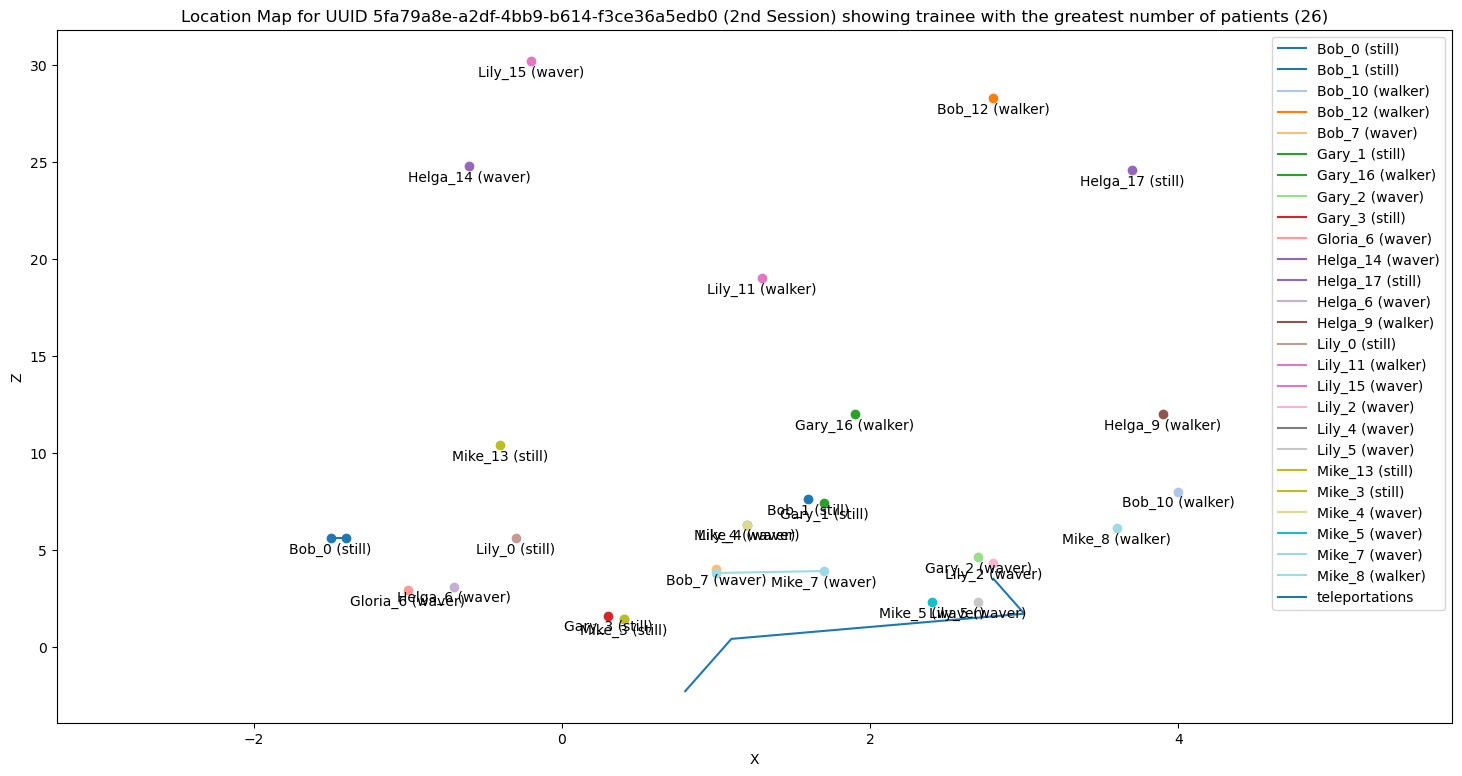

In [13]:

# Visualize the patients in a map
session_uuid = values_tuple[0]
scene_index = values_tuple[1]
base_mask_series = (frvrs_logs_df.session_uuid == session_uuid) & (frvrs_logs_df.scene_index == scene_index)

title = f'Location Map for UUID {session_uuid} ({humanize.ordinal(scene_index+1)} Session)'
title += ' showing responder with the greatest number of patients ('
title += humanize.intword(max_ranking) + ')'
nu.visualize_player_movement(base_mask_series, title=title, frvrs_logs_df=frvrs_logs_df)

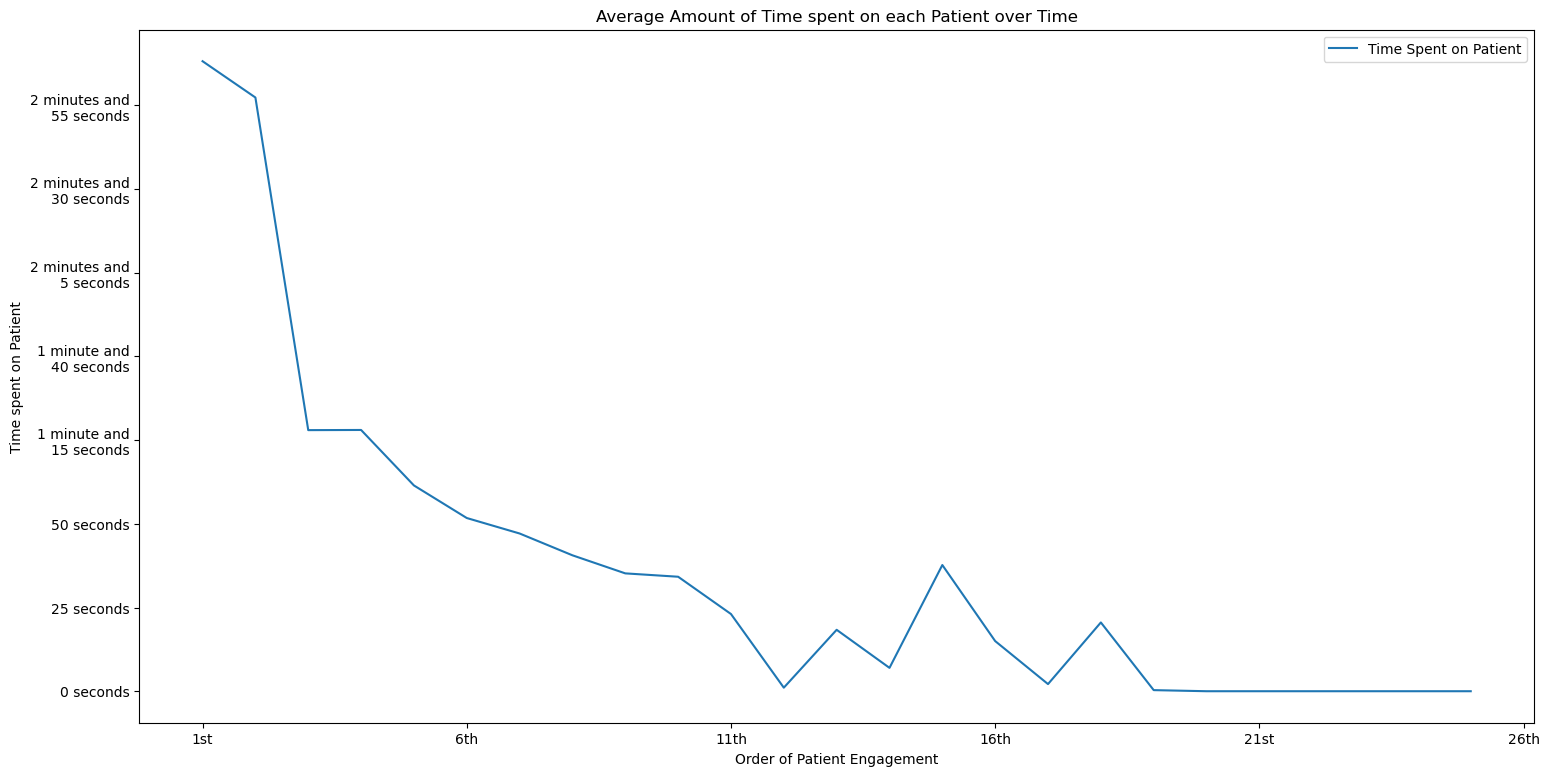

In [14]:

# Display average amount of time spent on each patient over time without error bars
ax = plt.figure(figsize=(18, 9)).add_subplot(1, 1, 1)
patient_ranking_df.dropna(axis='index', how='any').groupby('patient_ranking').mean().reset_index(drop=False).plot(
    x='patient_ranking', y='engagement_delta', kind='line', label='Time Spent on Patient', ax=ax
)
ax.set_title('Average Amount of Time spent on each Patient over Time')
ax.set_xlabel('Order of Patient Engagement')
ax.set_ylabel('Time spent on Patient')

# Humanize y tick labels
yticklabels_list = []
for text_obj in ax.get_yticklabels():
    text_obj.set_text(
        humanize.precisedelta(timedelta(milliseconds=text_obj.get_position()[1])).replace(', ', ',\n').replace(' and ', ' and\n')
    )
    yticklabels_list.append(text_obj)
ax.set_yticklabels(yticklabels_list)

# Humanize x tick labels
xticklabels_list = []
for text_obj in ax.get_xticklabels():
    text_obj.set_text(
        humanize.ordinal(int(text_obj.get_position()[0])+1)
    )
    xticklabels_list.append(text_obj)
ax.set_xticklabels(xticklabels_list);

In [15]:

# Get the top four overengaged patients
columns_list = [f'delta{i:02d}' for i in range(max_delta_count)]
mean_df = engagement_delta_df.groupby('patient_id').mean()[columns_list]
mask_series = [False] * mean_df.shape[0]; counter = max_delta_count
df = mean_df[mask_series].sort_values('delta00', ascending=False)
while(df.shape[0] < 4):
    counter -= 1
    mask_series = ~mean_df[f'delta{counter:02d}'].isnull()
    df = mean_df[mask_series].sort_values('delta00', ascending=False)

NameError: name 'max_delta_count' is not defined

In [ ]:

# Visualize the top four overengaged patients
fig, ax = plt.subplots(figsize=(18, 8))
df.plot(kind='bar', ax=ax)
yticklabels_list = []
for text_obj in ax.get_yticklabels():
    text_obj.set_text(
        humanize.precisedelta(timedelta(milliseconds=text_obj.get_position()[1])).replace(', ', ',\n').replace(' and ', ' and\n')
    )
    yticklabels_list.append(text_obj)
ax.set_yticklabels(yticklabels_list)

# Set the legend text objects
legend_texts = plt.legend().get_texts()
for i in range(max_delta_count): legend_texts[i].set_text(f'{humanize.ordinal(i+1)} Engagement')
ax.set_title(f'Patients with at least {humanize.intword(counter).title()} Engagements')
ax.set_xlabel('UnityEngine.GameObject Patient ID')
ax.set_ylabel('Mean Time between Patient Engagements');